In [1]:
%matplotlib notebook
import numpy as np
import networkx as nx
import pandas as pd
import mpld3
from matplotlib import pyplot as plt, cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import axes3d
from synthetic_data import load_data_by_gtype
from ic import sample_graph_from_infection, make_partial_cascade, infection_time_estimation
from graph_generator import add_p_and_delta
from tqdm import tqdm
from joblib import Parallel, delayed

In [40]:
gtype = 'kr-hier'
param = '10-8'
N1 = 500  # experiment round
N2 = 100  # simulation rounds
p = 0.7
q = 0.01
g = load_data_by_gtype(gtype, param)[0]
print('|V|={}'.format(g.number_of_nodes()))

|V|=254


In [41]:
def source_likelihood_given_single_obs(g, o, t, N):
    matching_count = np.zeros(g.number_of_nodes(), dtype=np.float64)
    for i in range(N):
        sg = sample_graph_from_infection(g)
        sp_len = nx.shortest_path_length(sg, source=o)
        times = np.array([sp_len.get(n, float('inf')) for n in np.arange(g.number_of_nodes())])
        matching_count += (times == t)
    return matching_count / N


In [42]:
def source_likelihood_given_obs_pair(g, o1, t1, o2, t2, N):
    pass

In [5]:
def source_likelihood_ratios_and_dists(g, p, q, N1, N2, s2n_proba, debug=True):
    g = add_p_and_delta(g, p, 1)
    source_likelihood_array = []
    sources = []
    dist_array = []
    def extract_proba(s, o, t):
        m = s2n_proba[s]
        if infection_times[o] < m.shape[1]:
            return m[o, infection_times[o]]
        else:
            return 0.001
    if debug:
        iters = tqdm(range(N1))
    else:
        iters = range(N1)
    for i in iters:
        source, obs_nodes, infection_times, _ = make_partial_cascade(g, q, 'uniform')
        sources.append(source)
        source_likelihood = np.ones(g.number_of_nodes(), dtype=np.float64)
        for o in obs_nodes:
            source_likelihood *= np.array([extract_proba(s, o, infection_times[o])
                                           for s in np.arange(g.number_of_nodes())])
            source_likelihood /= source_likelihood.sum()
            # source_likelihood_given_single_obs(g, o, infection_times[o], N2)
        max_n = np.argmax(source_likelihood)
        dist_to_max_n = nx.shortest_path_length(g, source=source, target=max_n)
        dist_array.append(dist_to_max_n)
        source_likelihood_array.append(source_likelihood)
    source_likelihood_array = np.array(source_likelihood_array, dtype=np.float64)
    source_llh = np.array([source_likelihood_array[i, src]
                           for i, src in enumerate(sources)])
    ratios = source_llh / source_likelihood_array.max(axis=1)
    return {
        'ratio': pd.Series(ratios[np.invert(np.isnan(ratios))]).describe(),
        'dist': pd.Series(dist_array).describe()
    }

In [6]:
ps = np.linspace(0.1, 1.0, 10)
qs = np.linspace(0.1, 1.0, 10)
p2sn_proba = {p: infection_time_estimation(add_p_and_delta(g, p, 1), N2, debug=False) for p in ps}

100%|██████████| 64/64 [00:00<00:00, 493.60it/s]


In [7]:
r = source_likelihood_ratios_and_dists(g, p, q, N1, N2, p2sn_proba[0.70000000000000007])
print(r)

100%|██████████| 100/100 [00:00<00:00, 186.91it/s]

{'dist': count    100.000000
mean       1.690000
std        0.677115
min        0.000000
25%        1.000000
50%        2.000000
75%        2.000000
max        3.000000
dtype: float64, 'ratio': count    100.000000
mean       0.692716
std        0.259907
min        0.000000
25%        0.490000
50%        0.730000
75%        0.913454
max        1.000000
dtype: float64}


In [19]:
rows = Parallel(n_jobs=-1)(delayed(source_likelihood_ratios_and_dists)(g, p, q, N1, N2, p2sn_proba[p], debug=False)
                           for p in tqdm(ps) for q in qs)


 10%|█         | 1/10 [00:00<00:08,  1.12it/s]/home/cloud-user/code/source_finding/venv/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide
/home/cloud-user/code/source_finding/venv/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide
/home/cloud-user/code/source_finding/venv/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide
/home/cloud-user/code/source_finding/venv/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide
/home/cloud-user/code/source_finding/venv/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide
/home/cloud-user/code/source_finding/venv/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in true_divide
/home/cloud-user/code/source_finding

<IPython.core.display.Javascript object>


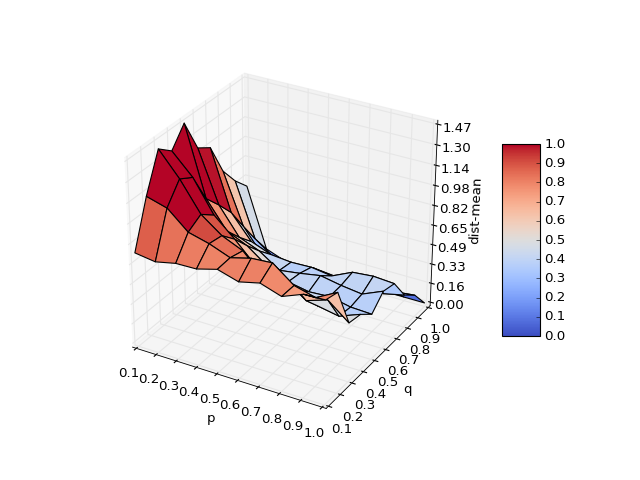

In [38]:
# mpld3.enable_notebook()
fig = plt.figure()
X, Y = np.meshgrid(ps, qs)
ratio_median = np.array([r['ratio']['50%'] for r in rows]).reshape((len(ps), len(qs)))
ratio_mean = np.array([r['ratio']['mean'] for r in rows]).reshape((len(ps), len(qs)))
dist_median = np.array([r['dist']['50%'] for r in rows]).reshape((len(ps), len(qs)))
dist_mean = np.array([r['dist']['mean'] for r in rows]).reshape((len(ps), len(qs)))
to_draw_data = {
    'ratio-median': ratio_median,
    'ratio-mean': ratio_mean,
    'dist-median': dist_median,
    'dist-mean': dist_mean,
}

for name, Z in to_draw_data.items():
    plt.clf()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(X, Y, Z, 
                           rstride=1, cstride=1,
                           vmin=0, vmax=1,
                           cmap=cm.coolwarm)
    ax.set_zlim(0, Z.max())
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, shrink=0.5, aspect=5)    

    ax.set_xlabel('p')
    ax.set_ylabel('q')
    ax.set_zlabel(name)
    plt.show()
    fig.savefig('figs/{}/{}-vs-p-and-q.png'.format(gtype, name))
# .display()

In [39]:
np.savez('figs/{}/source-likelihood-vs-p-and-q-data'.format(gtype), [X, Y, ratio_median, ratio_mean, dist_median, dist_mean])